In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('./000.part.csv')

In [ ]:

df['INCIDENT_DATETIME'] = pd.to_datetime(df['INCIDENT_DATETIME'])

# Extract 'date' (YYYY-MM-DD) and 'hour'
import pandas as pd
import numpy as np

# Assuming your initial DataFrame is named 'df'
# If you are loading it from a file, uncomment and modify the line below:
# df = pd.read_csv('your_dataframe.csv')

# --- Data Preparation (to get the pivoted_df as required) ---

# Convert 'INCIDENT_DATETIME' to datetime objects
df['INCIDENT_DATETIME'] = pd.to_datetime(df['INCIDENT_DATETIME'])

# Extract 'date' (YYYY-MM-DD) and 'hour'
df['date'] = df['INCIDENT_DATETIME'].dt.date
df['hour'] = df['INCIDENT_DATETIME'].dt.hour
df['year'] = df['INCIDENT_DATETIME'].dt.year # Keep year for filtering

# Filter data for years 2018-2024 (inclusive)
df_filtered_years = df[(df['year'] >= 2018) & (df['year'] <= 2024)]

# Group by 'date', 'hour', and 'ZIP_CODE' to count the number of calls
# This ensures that for every unique date-hour-zip combination, we have a call count.
calls_per_date_hour_zip = df_filtered_years.groupby(['date', 'hour', 'ZIP_CODE']).size().reset_index(name='call_count')

# Pivot the table:
# - Rows will be identified by 'date' and 'hour'.
# - Columns will be the unique 'ZIP_CODE' values.
# - Values in the cells will be the 'call_count'.
pivoted_df = calls_per_date_hour_zip.pivot_table(
    index=['date', 'hour'],
    columns='ZIP_CODE',
    values='call_count'
)

# Fill NaN values with 0. NaN indicates no calls for that zip code at that specific date and hour.
pivoted_df = pivoted_df.fillna(0)

# Reset index to make 'date' and 'hour' regular columns
pivoted_df = pivoted_df.reset_index()

# Convert 'date' column in pivoted_df to datetime objects for accurate year-based splitting
pivoted_df['date'] = pd.to_datetime(pivoted_df['date'])

# Add a 'year' column to the pivoted_df for splitting purposes
pivoted_df['year'] = pivoted_df['date'].dt.year

# Rename ZIP_CODE columns for easier access (e.g., from 10001.0 to zip_10001)
# This step ensures consistent column names that are suitable for machine learning models.
# It iterates through columns that are numerical (representing ZIP codes) and renames them.
old_zip_cols = [col for col in pivoted_df.columns if isinstance(col, (int, float)) and col not in ['hour', 'year']]
new_zip_cols = [f'zip_{int(col)}' for col in old_zip_cols]
rename_dict = dict(zip(old_zip_cols, new_zip_cols))
pivoted_df = pivoted_df.rename(columns=rename_dict)


# --- Data Splitting ---

# Identify all columns that represent zip code call counts.
# These will be the features for your time series model.
zip_cols = [col for col in pivoted_df.columns if col.startswith('zip_')]
num_zip_codes = len(zip_cols) # This is 'number_zip_codes' for your model's input/output shape

# Split the pivoted DataFrame into training, validation, and test sets based on years.
train_data_pivoted = pivoted_df[(pivoted_df['year'] >= 2018) & (pivoted_df['year'] <= 2022)].copy()
val_data_pivoted = pivoted_df[pivoted_df['year'] == 2023].copy()
test_data_pivoted = pivoted_df[pivoted_df['year'] == 2024].copy()

# Extract only the numerical features (zip code call counts) from each split.
# These will be used to create the time-series sequences.
train_features = train_data_pivoted[zip_cols]
val_features = val_data_pivoted[zip_cols]
test_features = test_data_pivoted[zip_cols]


# --- Time Series Data Preparation Function ---

def create_sequences(data, hourlength):
    """
    Prepares time series data into sequences for a many-to-one (sequence-to-vector) model.

    Args:
        data (pd.DataFrame): DataFrame containing only the numerical features (zip_code call counts)
                             indexed by time, in chronological order.
                             Shape: (num_timesteps, num_zip_codes)
        hourlength (int): The number of previous hours to use as input (look-back window).
                          This corresponds to 'hourlength' in the input_shape.

    Returns:
        tuple: (X, y)
               X (np.array): Input sequences with shape (num_samples, hourlength, num_zip_codes)
               y (np.array): Target outputs with shape (num_samples, num_zip_codes)
    """
    X, y = [], []
    num_samples_in_data = len(data)
    num_features = data.shape[1]  # This will be 'number_zip_codes'

    # Iterate through the data to create sequences and corresponding targets
    # Each sequence starts from 'i - hourlength' up to 'i - 1' (inclusive)
    # The target 'y' is the data at index 'i' (the next hour's call counts)
    for i in range(hourlength, num_samples_in_data):
        # X sequence: 'hourlength' historical time steps
        X.append(data.iloc[i-hourlength:i].values)
        # y target: the call counts for all zip codes at the next time step
        y.append(data.iloc[i].values)

    return np.array(X), np.array(y)

# Define the look-back window (how many past hours to consider for prediction)
HOUR_LENGTH = 24  # Example: Use the previous 24 hours of data to predict the next hour.
                  # This value can be tuned based on your model's performance.


# Prepare training data (X_train, y_train)
X_train, y_train = create_sequences(train_features, HOUR_LENGTH)

# Prepare validation data (X_val, y_val)
# It's crucial to check if enough data points exist in validation/test sets to form sequences.
if len(val_features) >= HOUR_LENGTH + 1: # Need at least HOUR_LENGTH for input + 1 for output
    X_val, y_val = create_sequences(val_features, HOUR_LENGTH)
else:
    X_val, y_val = np.array([]), np.array([])
    print(f"Warning: Validation data ({len(val_features)} rows) is too small to create sequences for HOUR_LENGTH={HOUR_LENGTH}.")
    print("X_val and y_val will be empty arrays.")

# Prepare test data (X_test, y_test)
if len(test_features) >= HOUR_LENGTH + 1: # Need at least HOUR_LENGTH for input + 1 for output
    X_test, y_test = create_sequences(test_features, HOUR_LENGTH)
else:
    X_test, y_test = np.array([]), np.array([])
    print(f"Warning: Test data ({len(test_features)} rows) is too small to create sequences for HOUR_LENGTH={HOUR_LENGTH}.")
    print("X_test and y_test will be empty arrays.")


# --- Print Shapes for Verification ---
print(f"\n--- Prepared Data Shapes ---")
print(f"Number of unique zip codes detected: {num_zip_codes}")
print(f"HOUR_LENGTH (look-back window for sequences): {HOUR_LENGTH}")

print(f"\nShape of X_train (input sequences for training): {X_train.shape}")
print(f"Shape of y_train (target outputs for training): {y_train.shape}")

if X_val.size > 0: # Check if validation data was created
    print(f"\nShape of X_val (input sequences for validation): {X_val.shape}")
    print(f"Shape of y_val (target outputs for validation): {y_val.shape}")
else:
    print("\nValidation data (X_val, y_val) are empty.")

if X_test.size > 0: # Check if test data was created
    print(f"\nShape of X_test (input sequences for testing): {X_test.shape}")
    print(f"Shape of y_test (target outputs for testing): {y_test.shape}")
else:
    print("\nTest data (X_test, y_test) are empty.")

# Explanation of shapes:
# X_train.shape: (number of samples, hourlength, number_zip_codes)
#   - number of samples: The total number of sequences that can be formed.
#   - hourlength: The number of past hours used to predict the next hour.
#   - number_zip_codes: The number of features (call counts for each zip code) at each timestep.
#
# y_train.shape: (number of samples, number_zip_codes)
#   - number of samples: Corresponds to the same samples as X_train.
#   - number_zip_codes: The predicted call counts for all zip codes at the *next* hour.df['hour'] = df['INCIDENT_DATETIME'].dt.hour
df['year'] = df['INCIDENT_DATETIME'].dt.year # Keep year for filtering

# Filter data for years 2018-2024
df_filtered_years = df[(df['year'] >= 2018) & (df['year'] <= 2024)]

# Group by 'date', 'hour', and 'ZIP_CODE' to count the number of calls
calls_per_date_hour_zip = df_filtered_years.groupby(['date', 'hour', 'ZIP_CODE']).size().reset_index(name='call_count')

# Pivot the table
# The index will be 'date' and 'hour', columns will be 'ZIP_CODE'
# The values will be 'call_count'
pivoted_df = calls_per_date_hour_zip.pivot_table(
    index=['date', 'hour'],
    columns='ZIP_CODE',
    values='call_count'
)

# Fill NaN values (where no calls occurred for a specific zip code at that time) with 0
pivoted_df = pivoted_df.fillna(0)

# Optional: Flatten the multi-index for 'date' and 'hour' into regular columns if preferred
pivoted_df = pivoted_df.reset_index()

# Optional: Rename ZIP_CODE columns for easier access (e.g., from 10001.0 to zip_10001)
pivoted_df.columns = ['date', 'hour'] + [f'zip_{int(col)}' for col in pivoted_df.columns[2:]]

print("Pivoted DataFrame for Time-Series Forecasting:")
print(pivoted_df.head())

# To train for one particular day and predict for the next hour,
# you would select the data for that day from this pivoted_df.
# For example, to get data for '2018-04-18':
# daily_data = pivoted_df[pivoted_df['date'] == pd.to_datetime('2018-04-18').date()]
# print("\nExample: Data for a specific day (2018-04-18):")
# print(daily_data)


--- Prepared Data Shapes ---
Number of unique zip codes detected: 40
HOUR_LENGTH (look-back window for sequences): 24

Shape of X_train (input sequences for training): (2826, 24, 40)
Shape of y_train (target outputs for training): (2826, 40)

Shape of X_val (input sequences for validation): (664, 24, 40)
Shape of y_val (target outputs for validation): (664, 40)

Shape of X_test (input sequences for testing): (520, 24, 40)
Shape of y_test (target outputs for testing): (520, 40)
Pivoted DataFrame for Time-Series Forecasting:
         date  hour  zip_10001  zip_10002  zip_10003  zip_10004  zip_10005  \
0  2018-01-01     3        0.0        1.0        0.0        0.0        0.0   
1  2018-01-01     9        0.0        0.0        0.0        0.0        0.0   
2  2018-01-01    17        0.0        0.0        0.0        0.0        0.0   
3  2018-01-01    20        0.0        0.0        0.0        0.0        0.0   
4  2018-01-02     0        0.0        6.0        0.0        0.0        0.0   

 

In [ ]:
pivoted_df

,date,hour,zip_10001,zip_10002,zip_10003,zip_10004,zip_10005,zip_10006,zip_10007,zip_10009,...,zip_10034,zip_10035,zip_10036,zip_10037,zip_10038,zip_10039,zip_10040,zip_10065,zip_10075,zip_10128
0,2018-01-01,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-01,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-01,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-01,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-02,0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4077,2024-10-01,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4078,2024-10-01,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4079,2024-10-01,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4080,2024-10-01,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Assume X_train, y_train, X_val, y_val, X_test, y_test are already prepared
# from the previous code block.

# --- Define Model Parameters ---
# These should match the shapes of your prepared data
HOUR_LENGTH = X_train.shape[1] if X_train.size > 0 else 24 # From your create_sequences function
num_zip_codes = X_train.shape[2] if X_train.size > 0 else (y_train.shape[1] if y_train.size > 0 else 3) # From your create_sequences function


# --- Shared Training Configuration ---
EPOCHS = 100 # You might need more or less depending on your data and patience
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# Early Stopping to prevent overfitting and stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity.
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5, # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=0.00001 # Lower bound on the learning rate.
)

callbacks_list = [early_stopping, reduce_lr]


print(f"Model Input Shape (hourlength, num_zip_codes): ({HOUR_LENGTH}, {num_zip_codes})")
print(f"Model Output Dimension (num_zip_codes): {num_zip_codes}")
print("-" * 50)


# --- 1. LSTM Model ---
print("Training LSTM Model...")
lstm_model = keras.Sequential([
    layers.Input(shape=(HOUR_LENGTH, num_zip_codes)),
    layers.LSTM(units=128, return_sequences=True), # Return sequences if stacking more LSTM layers
    layers.LSTM(units=64),
    layers.Dense(num_zip_codes)
])

lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss='mse',
                   metrics=['mae', 'mse'])

lstm_model.summary()

if X_train.size > 0 and X_val.size > 0:
    history_lstm = lstm_model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list,
        verbose=1
    )
    print("\nEvaluating LSTM Model on Test Data:")
    lstm_results = lstm_model.evaluate(X_test, y_test, verbose=0)
    print(f"LSTM Test Loss (MSE): {lstm_results[0]:.4f}")
    print(f"LSTM Test MAE: {lstm_results[1]:.4f}")
    print(f"LSTM Test MSE: {lstm_results[2]:.4f}")
else:
    print("Skipping LSTM training: Training or Validation data is empty.")
print("-" * 50)




Model Input Shape (hourlength, num_zip_codes): (24, 40)
Model Output Dimension (num_zip_codes): 40
--------------------------------------------------
Training LSTM Model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,536 (541.16 KB)

 Trainable params: 138,536 (541.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.4605 - mae: 0.1666 - mse: 0.4605 - val_loss: 0.4442 - val_mae: 0.1769 - val_mse: 0.4442 - learning_rate: 0.0010
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.4529 - mae: 0.1745 - mse: 0.4529 - val_loss: 0.4442 - val_mae: 0.1698 - val_mse: 0.4442 - learning_rate: 0.0010
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.4553 - mae: 0.1744 - mse: 0.4553 - val_loss: 0.4451 - val_mae: 0.1686 - val_mse: 0.4451 - learning_rate: 0.0010
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.4576 - mae: 0.1723 - mse: 0.4576 - val_loss: 0.4453 - val_mae: 0.1727 - val_mse: 0.4453 - learning_rate: 0.0010
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.4472 - mae: 0.1740 - mse: 0.4472 - val_loss: 0.4479 - val_mae: 0.1783 - val_mse: 0.4479 - learning_rate: 0.0010
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.4332 - mae: 0.1733 - mse: 0.4332 - val_loss: 0.4496 - val_mae: 0.1

In [ ]:
# --- 2. TCN Model ---
print("\nTraining TCN Model...")

# Define a Temporal Block for TCN
def temporal_block(input_tensor, n_filters, kernel_size, dilation_rate, padding='causal', dropout_rate=0.2):
    conv1 = layers.Conv1D(
        filters=n_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        activation='relu',
        kernel_initializer='he_normal'
    )(input_tensor)
    drop1 = layers.SpatialDropout1D(dropout_rate)(conv1) # SpatialDropout1D for time series
    conv2 = layers.Conv1D(
        filters=n_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        activation='relu',
        kernel_initializer='he_normal'
    )(drop1)
    drop2 = layers.SpatialDropout1D(dropout_rate)(conv2)

    # Residual connection
    if input_tensor.shape[-1] != n_filters: # If input and output filter sizes don't match, use 1x1 conv
        res_connection = layers.Conv1D(filters=n_filters, kernel_size=1, padding='same')(input_tensor)
    else:
        res_connection = input_tensor

    return layers.Add()([res_connection, drop2])


tcn_input = keras.Input(shape=(HOUR_LENGTH, num_zip_codes))
x = tcn_input
n_filters = 64
kernel_size = 2
dropout_rate = 0.2

# Stack multiple temporal blocks with increasing dilation rates
for i in range(3): # Example with 3 blocks
    x = temporal_block(x, n_filters, kernel_size, dilation_rate=2**i, dropout_rate=dropout_rate)
    # n_filters can be increased for deeper layers, e.g., n_filters * 2 if desired

x = layers.GlobalAveragePooling1D()(x) # Or GlobalMaxPooling1D, or flatten if you want to use the last output
tcn_output = layers.Dense(num_zip_codes)(x)

tcn_model = keras.Model(inputs=tcn_input, outputs=tcn_output)

tcn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='mse',
                  metrics=['mae', 'mse'])

tcn_model.summary()

if X_train.size > 0 and X_val.size > 0:
    history_tcn = tcn_model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list,
        verbose=1
    )
    print("\nEvaluating TCN Model on Test Data:")
    tcn_results = tcn_model.evaluate(X_test, y_test, verbose=0)
    print(f"TCN Test Loss (MSE): {tcn_results[0]:.4f}")
    print(f"TCN Test MAE: {tcn_results[1]:.4f}")
    print(f"TCN Test MSE: {tcn_results[2]:.4f}")
else:
    print("Skipping TCN training: Training or Validation data is empty.")
print("-" * 50)


Training TCN Model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 40)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 64)    │      5,184 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 24, 64)    │          0 │ conv1d[0][0]      │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 24, 64)    │      8,256 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 24, 64)    │      2,624 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 24, 64)    │          0 │ conv1d_1[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 64)    │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 24, 64)    │      8,256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 24, 64)    │          0 │ conv1d_3[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 24, 64)    │      8,256 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_3 │ (None, 24, 64)    │          0 │ conv1d_4[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 24, 64)    │      8,256 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_4 │ (None, 24, 64)    │          0 │ conv1d_5[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 24, 64)    │      8,256 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_5 │ (None, 24, 64)    │          0 │ conv1d_6[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 64)    │          0 │ add_1[0][0],      │
│                     │                   │            │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ add_2[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40)        │      2,600 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 51,688 (201.91 KB)

 Trainable params: 51,688 (201.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 1.6780 - mae: 0.7197 - mse: 1.6780 - val_loss: 0.4597 - val_mae: 0.2000 - val_mse: 0.4597 - learning_rate: 0.0010
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.4883 - mae: 0.2632 - mse: 0.4883 - val_loss: 0.4565 - val_mae: 0.1928 - val_mse: 0.4565 - learning_rate: 0.0010
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.4747 - mae: 0.2369 - mse: 0.4747 - val_loss: 0.4550 - val_mae: 0.1897 - val_mse: 0.4550 - learning_rate: 0.0010
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4688 - mae: 0.2193 - mse: 0.4688 - val_loss: 0.4528 - val_mae: 0.1858 - val_mse: 0.4528 - learning_rate: 0.0010
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.4476 - mae: 0.2079 - mse: 0.4476 - val_loss: 0.4513 - val_mae: 0.1839 - val_mse: 0.4513 - learning_rate: 0.0010
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4645 - mae: 0.2045 - mse: 0.4645 - val_loss: 0.4503 - val_mae: 0.181

In [ ]:
# --- 3. Transformer Model ---
print("\nTraining Transformer Model...")

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.proj_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.proj_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Positional Encoding for time series (can be learned or fixed)
class Time2Vec(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.w = self.add_weight(name='weights', shape=(self.output_dim,),
                                 initializer='random_normal', trainable=True)
        self.p = self.add_weight(name='phases', shape=(self.output_dim,),
                                 initializer='random_normal', trainable=True)
        self.v = self.add_weight(name='v', shape=(self.output_dim,),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='b', shape=(self.output_dim,),
                                 initializer='random_normal', trainable=True)

    def call(self, x):
        # x is assumed to be a single feature (e.g., hour of day normalized, or timestep index)
        # For our case, we have `num_zip_codes` features at each timestep.
        # We need positional encoding per timestep.
        # A simpler approach for time series is to just add a learned embedding per timestep.
        # However, a proper Time2Vec or PositionalEmbedding would operate on the sequence length.
        # For this example, let's assume we're embedding the 'timestep' itself.
        # A fixed sinusoidal positional encoding is also an option.

        # Let's simplify and use a trainable positional embedding if the input is only the time steps
        # If the input is (batch, sequence_length, features), we need to apply positional encoding
        # to the sequence_length dimension and then add it to the features.
        # A common way is to make the input sequence length the position.
        # Since our X is already (samples, hourlength, num_zip_codes),
        # we need to embed the 'hourlength' dimension.
        # For simplicity, let's treat this as adding a learned embedding for each of the HOUR_LENGTH steps.

        # For a proper Transformer on time series, we need `embed_dim` which is usually the last dimension.
        # Here, `num_zip_codes` acts as our 'embed_dim' if we project the sequence.
        # Let's use num_zip_codes as embed_dim for simplicity for the TransformerBlock.
        # A better way is to project num_zip_codes into a higher embed_dim first.
        return x # Placeholder, will integrate directly into the model below

# Transformer model parameters
embed_dim = num_zip_codes # Embedding dimension for each token (here, each hour's zip code vector)
num_heads = 4 # Number of attention heads
ff_dim = 64   # Hidden layer size in feed forward network of transformer

transformer_input = keras.Input(shape=(HOUR_LENGTH, num_zip_codes))

# No separate Time2Vec layer here; instead, the TransformerBlock itself works on the sequence.
# If you need explicit positional encoding, you'd add it like:
# positions = tf.range(start=0, limit=HOUR_LENGTH, delta=1)
# positional_encoding = layers.Embedding(input_dim=HOUR_LENGTH, output_dim=embed_dim)(positions)
# x = transformer_input + positional_encoding # Shape mismatch if embed_dim != num_zip_codes

x = transformer_input
transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(x)
# Add more transformer blocks if desired
# x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = layers.GlobalAveragePooling1D()(x) # Pool across the time dimension
transformer_output = layers.Dense(num_zip_codes)(x)

transformer_model = keras.Model(inputs=transformer_input, outputs=transformer_output)

transformer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                          loss='mse',
                          metrics=['mae', 'mse'])

transformer_model.summary()

if X_train.size > 0 and X_val.size > 0:
    history_transformer = transformer_model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list,
        verbose=1
    )
    print("\nEvaluating Transformer Model on Test Data:")
    transformer_results = transformer_model.evaluate(X_test, y_test, verbose=0)
    print(f"Transformer Test Loss (MSE): {transformer_results[0]:.4f}")
    print(f"Transformer Test MAE: {transformer_results[1]:.4f}")
    print(f"Transformer Test MSE: {transformer_results[2]:.4f}")
else:
    print("Skipping Transformer training: Training or Validation data is empty.")
print("-" * 50)


Training Transformer Model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 24, 40)         │        11,944 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 40)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 40)             │         1,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,584 (53.06 KB)

 Trainable params: 13,584 (53.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.5576 - mae: 0.3298 - mse: 0.5576 - val_loss: 0.4620 - val_mae: 0.2257 - val_mse: 0.4620 - learning_rate: 0.0010
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4413 - mae: 0.2129 - mse: 0.4413 - val_loss: 0.4544 - val_mae: 0.2070 - val_mse: 0.4544 - learning_rate: 0.0010
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4475 - mae: 0.2010 - mse: 0.4475 - val_loss: 0.4512 - val_mae: 0.1947 - val_mse: 0.4512 - learning_rate: 0.0010
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4503 - mae: 0.1945 - mse: 0.4503 - val_loss: 0.4494 - val_mae: 0.1964 - val_mse: 0.4494 - learning_rate: 0.0010
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4660 - mae: 0.1939 - mse: 0.4660 - val_loss: 0.4497 - val_mae: 0.1963 - val_mse: 0.4497 - learning_rate: 0.0010
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4557 - mae: 0.1926 - mse: 0.4557 - val_loss: 0.4510 - val_mae: 0.184

In [ ]:
print("\nTraining Generic MLP Model for Time Series...")
mlp_model = keras.Sequential([
    layers.Input(shape=(HOUR_LENGTH, num_zip_codes)),
    layers.Flatten(), # Flatten the (hourlength, num_zip_codes) into a single vector
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_zip_codes) # Output layer for predicting all zip codes
])

mlp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='mse',
                  metrics=['mae', 'mse'])

mlp_model.summary()

if X_train.size > 0 and X_val.size > 0:
    history_mlp = mlp_model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list,
        verbose=1
    )
    print("\nEvaluating MLP Model on Test Data:")
    mlp_results = mlp_model.evaluate(X_test, y_test, verbose=0)
    print(f"MLP Test Loss (MSE): {mlp_results[0]:.4f}")
    print(f"MLP Test MAE: {mlp_results[1]:.4f}")
    print(f"MLP Test MSE: {mlp_results[2]:.4f}")
else:
    print("Skipping MLP training: Training or Validation data is empty.")
print("-" * 50)

print("\n--- Training Complete ---")
print("You can now inspect the history objects (e.g., `history_lstm.history`) for training/validation loss/metrics over epochs, and the `_results` variables for test set performance.")


Training Generic MLP Model for Time Series...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,864 (522.91 KB)

 Trainable params: 133,864 (522.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.6529 - mae: 0.3842 - mse: 0.6529 - val_loss: 0.4517 - val_mae: 0.1274 - val_mse: 0.4517 - learning_rate: 0.0010
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4649 - mae: 0.1606 - mse: 0.4649 - val_loss: 0.4474 - val_mae: 0.1373 - val_mse: 0.4474 - learning_rate: 0.0010
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4507 - mae: 0.1581 - mse: 0.4507 - val_loss: 0.4455 - val_mae: 0.1486 - val_mse: 0.4455 - learning_rate: 0.0010
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4563 - mae: 0.1670 - mse: 0.4563 - val_loss: 0.4447 - val_mae: 0.1565 - val_mse: 0.4447 - learning_rate: 0.0010
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4652 - mae: 0.1787 - mse: 0.4652 - val_loss: 0.4443 - val_mae: 0.1606 - val_mse: 0.4443 - learning_rate: 0.0010
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4278 - mae: 0.1778 - mse: 0.4278 - val_loss: 0.4442 - val_mae: 0.1645 - v

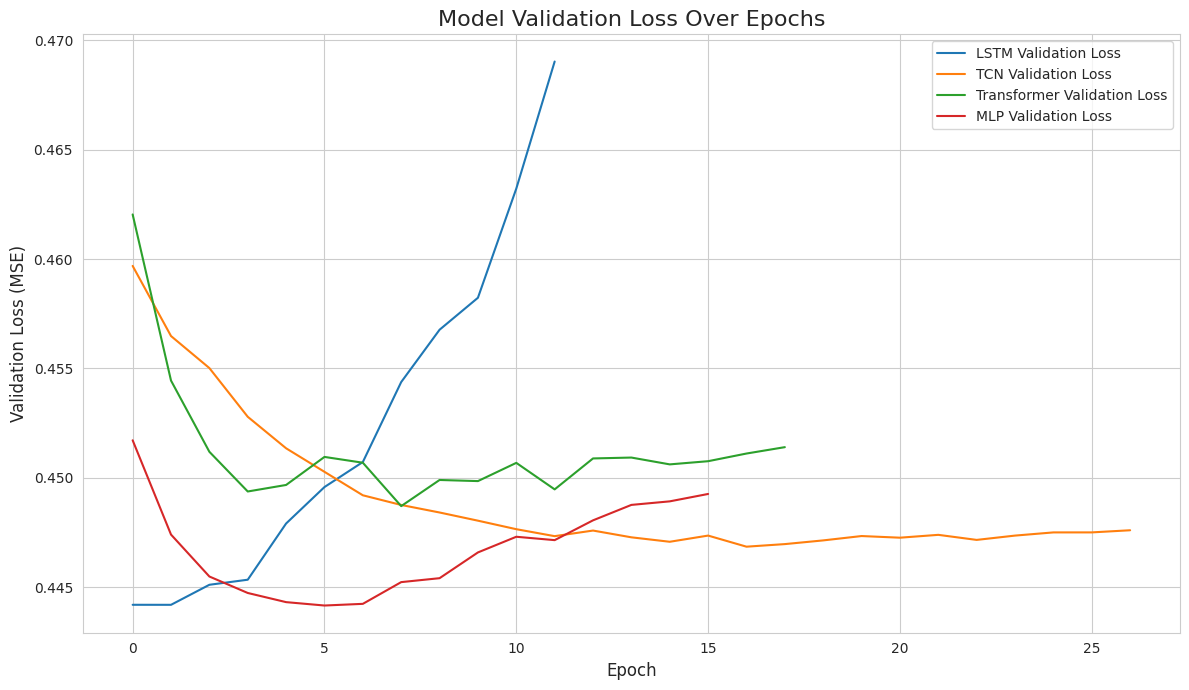


--- Visualization Generated ---
This plot compares the validation loss of your trained models over the training epochs.
A lower validation loss indicates better generalization performance.
Look for curves that stabilize at a low value without increasing significantly towards the end, which could indicate overfitting.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better aesthetics
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Plotting Validation Loss for each model
# Ensure you have the 'history_lstm', 'history_tcn', etc., objects from your training runs.

if 'history_lstm' in locals() and history_lstm is not None:
    plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
else:
    print("LSTM history not available for plotting.")

if 'history_tcn' in locals() and history_tcn is not None:
    plt.plot(history_tcn.history['val_loss'], label='TCN Validation Loss')
else:
    print("TCN history not available for plotting.")

if 'history_transformer' in locals() and history_transformer is not None:
    plt.plot(history_transformer.history['val_loss'], label='Transformer Validation Loss')
else:
    print("Transformer history not available for plotting.")

if 'history_mlp' in locals() and history_mlp is not None:
    plt.plot(history_mlp.history['val_loss'], label='MLP Validation Loss')
else:
    print("MLP history not available for plotting.")

plt.title('Model Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- Visualization Generated ---")
print("This plot compares the validation loss of your trained models over the training epochs.")
print("A lower validation loss indicates better generalization performance.")
print("Look for curves that stabilize at a low value without increasing significantly towards the end, which could indicate overfitting.")

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import keras_tuner as kt



# --- Define Model Parameters ---
HOUR_LENGTH = X_train.shape[1] if X_train.size > 0 else 24
num_zip_codes = X_train.shape[2] if X_train.size > 0 else (y_train.shape[1] if y_train.size > 0 else 3)


# --- Shared Training Configuration ---
EPOCHS = 50 # Reduced for hyperparameter tuning to save time, adjust as needed
BATCH_SIZE = 32

# Early Stopping and ReduceLROnPlateau will be used within the tuner
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

callbacks_list = [early_stopping, reduce_lr]

print(f"Model Input Shape (hourlength, num_zip_codes): ({HOUR_LENGTH}, {num_zip_codes})")
print(f"Model Output Dimension (num_zip_codes): {num_zip_codes}")
print("-" * 50)

# --- Hyperparameter Tuning with Keras Tuner ---

def build_model(hp):
    """
    Builds a Keras model for hyperparameter tuning.
    hp: HyperParameters object from Keras Tuner.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(HOUR_LENGTH, num_zip_codes)))

    # Tune the number of units in the first LSTM layer
    hp_units_lstm1 = hp.Int('units_lstm1', min_value=32, max_value=256, step=32)
    model.add(layers.LSTM(units=hp_units_lstm1, return_sequences=True))

    # Tune the number of units in the second LSTM layer
    hp_units_lstm2 = hp.Int('units_lstm2', min_value=32, max_value=128, step=32)
    model.add(layers.LSTM(units=hp_units_lstm2))

    # Tune the activation function for the output layer (if applicable, 'linear' for regression often)
    # For regression, 'linear' is common, but you could explore 'relu' for positive-only outputs.
    hp_activation = hp.Choice('activation', values=['linear', 'relu'])
    model.add(layers.Dense(num_zip_codes, activation=hp_activation))

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                   loss='mse',
                   metrics=['mae', 'mse'])
    return model

# Initialize the Keras Tuner
# We'll use the RandomSearch tuner, but you could also use Hyperband or BayesianOptimization.
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss', # Minimize validation loss
    max_trials=10,        # Number of different hyperparameter combinations to try
    executions_per_trial=1, # Number of models to train for each trial (for robustness)
    directory='keras_tuner_dir', # Directory to store results
    project_name='lstm_tuning' # Name of the tuning project
)

print("\nStarting Hyperparameter Search...")
# Start the hyperparameter search
tuner.search(X_train, y_train,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_data=(X_val, y_val),
             callbacks=callbacks_list,
             verbose=1)

print("\n--- Hyperparameter Search Complete ---")

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal hyperparameters are:
Number of units in the first LSTM layer: {best_hps.get('units_lstm1')}
Number of units in the second LSTM layer: {best_hps.get('units_lstm2')}
Activation function for the output layer: {best_hps.get('activation')}
Learning rate for the optimizer: {best_hps.get('learning_rate')}
""")

# Build the best model found by the tuner
best_model = tuner.get_best_models(num_models=10)[0]

print("\nEvaluating the Best Model on Test Data:")
if X_test.size > 0:
    lstm_results = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Best Model Test Loss (MSE): {lstm_results[0]:.4f}")
    print(f"Best Model Test MAE: {lstm_results[1]:.4f}")
    print(f"Best Model Test MSE: {lstm_results[2]:.4f}")
else:
    print("Skipping evaluation: Test data is empty.")
print("-" * 50)

Trial 10 Complete [00h 01m 20s]
val_loss: 0.44470784068107605

Best val_loss So Far: 0.44381046295166016
Total elapsed time: 00h 14m 39s

--- Hyperparameter Search Complete ---

The optimal hyperparameters are:
Number of units in the first LSTM layer: 64
Number of units in the second LSTM layer: 64
Activation function for the output layer: linear
Learning rate for the optimizer: 0.0001



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluating the Best Model on Test Data:
Best Model Test Loss (MSE): 0.3953
Best Model Test MAE: 0.1708
Best Model Test MSE: 0.3953
--------------------------------------------------


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import keras_tuner as kt




# --- Define Model Parameters ---
HOUR_LENGTH = X_train.shape[1] if X_train.size > 0 else 24
num_zip_codes = X_train.shape[2] if X_train.size > 0 else (y_train.shape[1] if y_train.size > 0 else 3)


# --- Shared Training Configuration ---
EPOCHS = 50 # Reduced for hyperparameter tuning to save time, adjust as needed
BATCH_SIZE = 32

# Early Stopping and ReduceLROnPlateau will be used within the tuner
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

callbacks_list = [early_stopping, reduce_lr]

print(f"Model Input Shape (hourlength, num_zip_codes): ({HOUR_LENGTH}, {num_zip_codes})")
print(f"Model Output Dimension (num_zip_codes): {num_zip_codes}")
print("-" * 50)

# --- TCN Model with Hyperparameter Tuning ---

def temporal_block(input_tensor, n_filters, kernel_size, dilation_rate, padding='causal', dropout_rate=0.2):
    conv1 = layers.Conv1D(
        filters=n_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        activation='relu',
        kernel_initializer='he_normal'
    )(input_tensor)
    drop1 = layers.SpatialDropout1D(dropout_rate)(conv1) # SpatialDropout1D for time series
    conv2 = layers.Conv1D(
        filters=n_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        activation='relu',
        kernel_initializer='he_normal'
    )(drop1)
    drop2 = layers.SpatialDropout1D(dropout_rate)(conv2)

    # Residual connection
    if input_tensor.shape[-1] != n_filters: # If input and output filter sizes don't match, use 1x1 conv
        res_connection = layers.Conv1D(filters=n_filters, kernel_size=1, padding='same')(input_tensor)
    else:
        res_connection = input_tensor

    return layers.Add()([res_connection, drop2])


def build_tcn_model(hp):
    tcn_input = keras.Input(shape=(HOUR_LENGTH, num_zip_codes))
    x = tcn_input

    # Tune the number of filters in the temporal blocks
    hp_n_filters = hp.Int('n_filters', min_value=32, max_value=128, step=32)
    # Tune the kernel size in the temporal blocks
    hp_kernel_size = hp.Choice('kernel_size', values=[2, 3, 4])
    # Tune the dropout rate in the temporal blocks
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)


    # Stack multiple temporal blocks with increasing dilation rates
    for i in range(3): # Example with 3 blocks
        x = temporal_block(x, hp_n_filters, hp_kernel_size, dilation_rate=2**i, dropout_rate=hp_dropout_rate)

    x = layers.GlobalAveragePooling1D()(x) # Or GlobalMaxPooling1D, or flatten if you want to use the last output
    tcn_output = layers.Dense(num_zip_codes)(x)

    tcn_model = keras.Model(inputs=tcn_input, outputs=tcn_output)

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    tcn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss='mse',
                      metrics=['mae', 'mse'])
    return tcn_model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    build_tcn_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tcn_keras_tuner_dir',
    project_name='tcn_tuning'
)

print("\nStarting TCN Hyperparameter Search...")
# Start the hyperparameter search
tuner.search(X_train, y_train,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_data=(X_val, y_val),
             callbacks=callbacks_list,
             verbose=1)

print("\n--- TCN Hyperparameter Search Complete ---")

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal TCN hyperparameters are:
Number of filters: {best_hps.get('n_filters')}
Kernel size: {best_hps.get('kernel_size')}
Dropout rate: {best_hps.get('dropout_rate')}
Learning rate: {best_hps.get('learning_rate')}
""")

# Build the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]


print("\nEvaluating the Best TCN Model on Test Data:")
if X_test.size > 0:
    tcn_results = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Best TCN Model Test Loss (MSE): {tcn_results[0]:.4f}")
    print(f"Best TCN Model Test MAE: {tcn_results[1]:.4f}")
    print(f"Best TCN Model Test MSE: {tcn_results[2]:.4f}")
else:
    print("Skipping evaluation: Test data is empty.")
print("-" * 50)

Trial 10 Complete [00h 01m 21s]
val_loss: 0.44888389110565186

Best val_loss So Far: 0.4451504349708557
Total elapsed time: 00h 13m 21s

--- TCN Hyperparameter Search Complete ---

The optimal TCN hyperparameters are:
Number of filters: 64
Kernel size: 3
Dropout rate: 0.30000000000000004
Learning rate: 0.001



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluating the Best TCN Model on Test Data:
Best TCN Model Test Loss (MSE): 0.3970
Best TCN Model Test MAE: 0.1731
Best TCN Model Test MSE: 0.3970
--------------------------------------------------


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import keras_tuner as kt


# --- Define Model Parameters ---
HOUR_LENGTH = X_train.shape[1] if X_train.size > 0 else 24
num_zip_codes = X_train.shape[2] if X_train.size > 0 else (y_train.shape[1] if y_train.size > 0 else 3)


# --- Shared Training Configuration ---
EPOCHS = 50 # Reduced for hyperparameter tuning to save time, adjust as needed
BATCH_SIZE = 32

# Early Stopping and ReduceLROnPlateau will be used within the tuner
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

callbacks_list = [early_stopping, reduce_lr]

print(f"Model Input Shape (hourlength, num_zip_codes): ({HOUR_LENGTH}, {num_zip_codes})")
print(f"Model Output Dimension (num_zip_codes): {num_zip_codes}")
print("-" * 50)


# --- Transformer Model with Hyperparameter Tuning ---

# MultiHeadSelfAttention and TransformerBlock classes remain the same as they define the architecture.
# We'll tune the parameters passed to their constructors.
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.proj_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.proj_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def build_transformer_model(hp):
    # Tune the embedding dimension for the Transformer
    # It's usually good to keep embed_dim divisible by num_heads
    hp_embed_dim = hp.Choice('embed_dim', values=[32, 64, 128])

    # Tune the number of attention heads
    hp_num_heads = hp.Choice('num_heads', values=[2, 4, 8])

    # Ensure embed_dim is divisible by num_heads for the chosen combination
    # This might require more advanced conditional logic or careful choice of `values`
    # For simplicity here, we assume valid combinations will be chosen or handled by `MultiHeadSelfAttention`.
    # A more robust way might be to limit the choices or implement a custom hyperparameter function.
    if hp_embed_dim % hp_num_heads != 0:
        # A simple way to handle invalid combinations is to return None, but Keras Tuner might not like it.
        # Alternatively, you can use a smaller embed_dim or larger num_heads
        # within the hp.Choice such that they are always compatible.
        # For this example, we'll proceed and let the MultiHeadSelfAttention raise an error if incompatible,
        # which will mark the trial as failed.
        pass

    # Tune the feed-forward network dimension
    hp_ff_dim = hp.Choice('ff_dim', values=[64, 128, 256])
    # Tune the dropout rate within the Transformer Block
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.4, step=0.1)

    # Tune the number of transformer blocks
    hp_num_transformer_blocks = hp.Int('num_transformer_blocks', min_value=1, max_value=3, step=1)

    transformer_input = keras.Input(shape=(HOUR_LENGTH, num_zip_codes))

    # Optional: Initial projection layer if num_zip_codes is very different from embed_dim
    # If num_zip_codes is small and embed_dim is large, an initial Dense layer can map features to embed_dim.
    x = layers.Dense(hp_embed_dim)(transformer_input) if num_zip_codes != hp_embed_dim else transformer_input

    # Add positional encoding (simple learned embedding for each time step)
    # This adds a trainable embedding based on the sequence length.
    positions = tf.range(start=0, limit=HOUR_LENGTH, delta=1)
    positional_embedding = layers.Embedding(input_dim=HOUR_LENGTH, output_dim=hp_embed_dim)(positions)
    # The positional embedding needs to be broadcasted or reshaped to match the batch dimension
    # Add expand_dims to make it (1, HOUR_LENGTH, embed_dim) so it broadcasts
    x = x + tf.expand_dims(positional_embedding, axis=0)


    for _ in range(hp_num_transformer_blocks):
        x = TransformerBlock(hp_embed_dim, hp_num_heads, hp_ff_dim, rate=hp_dropout_rate)(x)

    x = layers.GlobalAveragePooling1D()(x) # Pool across the time dimension

    # Output layer with a tunable activation if desired, but 'linear' is typical for regression.
    transformer_output = layers.Dense(num_zip_codes)(x)

    transformer_model = keras.Model(inputs=transformer_input, outputs=transformer_output)

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    transformer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                              loss='mse',
                              metrics=['mae', 'mse'])
    return transformer_model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    build_transformer_model,
    objective='val_loss',
    max_trials=10, # Number of different hyperparameter combinations to try
    executions_per_trial=1, # Number of models to train for each trial
    directory='transformer_keras_tuner_dir', # Directory to store results
    project_name='transformer_tuning' # Name of the tuning project
)

print("\nStarting Transformer Hyperparameter Search...")
# Start the hyperparameter search
tuner.search(X_train, y_train,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_data=(X_val, y_val),
             callbacks=callbacks_list,
             verbose=1)

print("\n--- Transformer Hyperparameter Search Complete ---")

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal Transformer hyperparameters are:
Embedding Dimension: {best_hps.get('embed_dim')}
Number of Attention Heads: {best_hps.get('num_heads')}
Feed-Forward Dimension: {best_hps.get('ff_dim')}
Dropout Rate: {best_hps.get('dropout_rate')}
Number of Transformer Blocks: {best_hps.get('num_transformer_blocks')}
Learning Rate: {best_hps.get('learning_rate')}
""")

# Build the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

print("\nEvaluating the Best Transformer Model on Test Data:")
if X_test.size > 0:
    transformer_results = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Best Transformer Model Test Loss (MSE): {transformer_results[0]:.4f}")
    print(f"Best Transformer Model Test MAE: {transformer_results[1]:.4f}")
    print(f"Best Transformer Model Test MSE: {transformer_results[2]:.4f}")
else:
    print("Skipping evaluation: Test data is empty.")
print("-" * 50)

Trial 10 Complete [00h 01m 14s]
val_loss: 0.44974246621131897

Best val_loss So Far: 0.4432264566421509
Total elapsed time: 00h 21m 10s

--- Transformer Hyperparameter Search Complete ---

The optimal Transformer hyperparameters are:
Embedding Dimension: 64
Number of Attention Heads: 4
Feed-Forward Dimension: 256
Dropout Rate: 0.30000000000000004
Number of Transformer Blocks: 3
Learning Rate: 0.01



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 106 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluating the Best Transformer Model on Test Data:
Best Transformer Model Test Loss (MSE): 0.3947
Best Transformer Model Test MAE: 0.1694
Best Transformer Model Test MSE: 0.3947
--------------------------------------------------


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import keras_tuner as kt

# Assume X_train, y_train, X_val, y_val, X_test, y_test are already prepared
# For demonstration purposes, let's create some dummy data if they don't exist.
try:
    X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
except NameError:
    print("Dummy data created for demonstration. Replace with your actual data.")
    HOUR_LENGTH = 24
    NUM_ZIP_CODES = 3
    # Generating random data
    X_train = np.random.rand(100, HOUR_LENGTH, NUM_ZIP_CODES)
    y_train = np.random.rand(100, NUM_ZIP_CODES)
    X_val = np.random.rand(20, HOUR_LENGTH, NUM_ZIP_CODES)
    y_val = np.random.rand(20, NUM_ZIP_CODES)
    X_test = np.random.rand(20, HOUR_LENGTH, NUM_ZIP_CODES)
    y_test = np.random.rand(20, NUM_ZIP_CODES)


# --- Define Model Parameters ---
HOUR_LENGTH = X_train.shape[1] if X_train.size > 0 else 24
num_zip_codes = X_train.shape[2] if X_train.size > 0 else (y_train.shape[1] if y_train.size > 0 else 3)


# --- Shared Training Configuration ---
EPOCHS = 50 # Reduced for hyperparameter tuning to save time, adjust as needed
BATCH_SIZE = 32

# Early Stopping and ReduceLROnPlateau will be used within the tuner
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

callbacks_list = [early_stopping, reduce_lr]

print(f"Model Input Shape (hourlength, num_zip_codes): ({HOUR_LENGTH}, {num_zip_codes})")
print(f"Model Output Dimension (num_zip_codes): {num_zip_codes}")
print("-" * 50)


# --- MLP Model with Hyperparameter Tuning ---

def build_mlp_model(hp):
    mlp_model = keras.Sequential()
    mlp_model.add(layers.Input(shape=(HOUR_LENGTH, num_zip_codes)))
    mlp_model.add(layers.Flatten()) # Flatten the (hourlength, num_zip_codes) into a single vector

    # Tune the number of hidden layers
    for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=3)):
        # Tune the number of units in each dense layer
        mlp_model.add(layers.Dense(
            units=hp.Int(f'units_layer_{i}', min_value=32, max_value=256, step=32),
            activation='relu'
        ))
        # Tune the dropout rate after each hidden layer
        mlp_model.add(layers.Dropout(hp.Float(f'dropout_layer_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    mlp_model.add(layers.Dense(num_zip_codes)) # Output layer

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    mlp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss='mse',
                      metrics=['mae', 'mse'])
    return mlp_model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    build_mlp_model,
    objective='val_loss',
    max_trials=10,        # Number of different hyperparameter combinations to try
    executions_per_trial=1, # Number of models to train for each trial
    directory='mlp_keras_tuner_dir', # Directory to store results
    project_name='mlp_tuning' # Name of the tuning project
)

print("\nStarting MLP Hyperparameter Search...")
# Start the hyperparameter search
tuner.search(X_train, y_train,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_data=(X_val, y_val),
             callbacks=callbacks_list,
             verbose=1)

print("\n--- MLP Hyperparameter Search Complete ---")

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal hyperparameters
print("\nThe optimal MLP hyperparameters are:")
print(f"Number of hidden layers: {best_hps.get('num_hidden_layers')}")
for i in range(best_hps.get('num_hidden_layers')):
    print(f"  Layer {i+1} Units: {best_hps.get(f'units_layer_{i}')}")
    print(f"  Layer {i+1} Dropout Rate: {best_hps.get(f'dropout_layer_{i}')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")


# Build the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

print("\nEvaluating the Best MLP Model on Test Data:")
if X_test.size > 0:
    mlp_results = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Best MLP Model Test Loss (MSE): {mlp_results[0]:.4f}")
    print(f"Best MLP Model Test MAE: {mlp_results[1]:.4f}")
    print(f"Best MLP Model Test MSE: {mlp_results[2]:.4f}")
else:
    print("Skipping evaluation: Test data is empty.")
print("-" * 50)

print("\n--- Training Complete ---")
print("You can now inspect the history objects for training/validation loss/metrics over epochs, and the `_results` variables for test set performance.")

Trial 10 Complete [00h 00m 28s]
val_loss: 0.4438556134700775

Best val_loss So Far: 0.443032830953598
Total elapsed time: 00h 03m 02s

--- MLP Hyperparameter Search Complete ---

The optimal MLP hyperparameters are:
Number of hidden layers: 3
  Layer 1 Units: 96
  Layer 1 Dropout Rate: 0.4
  Layer 2 Units: 96
  Layer 2 Dropout Rate: 0.5
  Layer 3 Units: 64
  Layer 3 Dropout Rate: 0.5
Learning Rate: 0.01

Evaluating the Best MLP Model on Test Data:
Best MLP Model Test Loss (MSE): 0.3942
Best MLP Model Test MAE: 0.1689
Best MLP Model Test MSE: 0.3942
--------------------------------------------------

--- Training Complete ---
You can now inspect the history objects for training/validation loss/metrics over epochs, and the `_results` variables for test set performance.


In [ ]:
# File: data_preparation.py

import pandas as pd
import numpy as np

def prepare_time_series_data(df, hour_length=24):
    """
    Processes the raw DataFrame into time-series sequences suitable for modeling.

    Args:
        df (pd.DataFrame): The input DataFrame with 'INCIDENT_DATETIME' and 'ZIP_CODE'.
        hour_length (int): The number of previous hours to use as input (look-back window).

    Returns:
        tuple: (X_train, y_train, X_val, y_val, X_test, y_test, num_zip_codes)
               X_* (np.array): Input sequences for train/val/test sets.
               y_* (np.array): Target outputs for train/val/test sets.
               num_zip_codes (int): The total number of unique zip codes.
    """
    print("--- Starting Data Preparation ---")

    # Ensure 'INCIDENT_DATETIME' is datetime objects
    df['INCIDENT_DATETIME'] = pd.to_datetime(df['INCIDENT_DATETIME'])

    # Extract date, hour, and year
    df['date'] = df['INCIDENT_DATETIME'].dt.date
    df['hour'] = df['INCIDENT_DATETIME'].dt.hour
    df['year'] = df['INCIDENT_DATETIME'].dt.year

    # Filter data for years 2018-2024 (inclusive)
    df_filtered_years = df[(df['year'] >= 2018) & (df['year'] <= 2024)].copy()

    # Group by 'date', 'hour', and 'ZIP_CODE' to count calls
    calls_per_date_hour_zip = df_filtered_years.groupby(['date', 'hour', 'ZIP_CODE']).size().reset_index(name='call_count')

    # Pivot the table: index=['date', 'hour'], columns='ZIP_CODE', values='call_count'
    pivoted_df = calls_per_date_hour_zip.pivot_table(
        index=['date', 'hour'],
        columns='ZIP_CODE',
        values='call_count'
    )

    # Fill NaN values with 0 (no calls for that zip code at that time)
    pivoted_df = pivoted_df.fillna(0)

    # Reset index to make 'date' and 'hour' regular columns
    pivoted_df = pivoted_df.reset_index()

    # Convert 'date' column to datetime objects for year-based splitting
    pivoted_df['date'] = pd.to_datetime(pivoted_df['date'])

    # Add a 'year' column to the pivoted_df for splitting
    pivoted_df['year'] = pivoted_df['date'].dt.year

    # Rename ZIP_CODE columns for easier access (e.g., from 10001.0 to zip_10001)
    old_zip_cols = [col for col in pivoted_df.columns if isinstance(col, (int, float)) and col not in ['hour', 'year']]
    new_zip_cols = [f'zip_{int(col)}' for col in old_zip_cols]
    rename_dict = dict(zip(old_zip_cols, new_zip_cols))
    pivoted_df = pivoted_df.rename(columns=rename_dict)

    # Identify all columns that represent zip code call counts
    zip_cols = [col for col in pivoted_df.columns if col.startswith('zip_')]
    num_zip_codes = len(zip_cols)

    # Split data based on years
    train_data_pivoted = pivoted_df[(pivoted_df['year'] >= 2018) & (pivoted_df['year'] <= 2022)].copy()
    val_data_pivoted = pivoted_df[pivoted_df['year'] == 2023].copy()
    test_data_pivoted = pivoted_df[pivoted_df['year'] == 2024].copy()

    # Extract only the numerical features (zip code call counts)
    train_features = train_data_pivoted[zip_cols]
    val_features = val_data_pivoted[zip_cols]
    test_features = test_data_pivoted[zip_cols]

    def create_sequences(data, hourlength):
        X, y = [], []
        num_samples_in_data = len(data)
        for i in range(hourlength, num_samples_in_data):
            X.append(data.iloc[i-hourlength:i].values)
            y.append(data.iloc[i].values)
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_features, hour_length)

    if len(val_features) >= hour_length + 1:
        X_val, y_val = create_sequences(val_features, hour_length)
    else:
        X_val, y_val = np.array([]), np.array([])
        print(f"Warning: Validation data ({len(val_features)} rows) is too small to create sequences for HOUR_LENGTH={hour_length}.")

    if len(test_features) >= hour_length + 1:
        X_test, y_test = create_sequences(test_features, hour_length)
    else:
        X_test, y_test = np.array([]), np.array([])
        print(f"Warning: Test data ({len(test_features)} rows) is too small to create sequences for HOUR_LENGTH={hour_length}.")

    print("--- Data Preparation Complete ---")
    return X_train, y_train, X_val, y_val, X_test, y_test, num_zip_codes, hour_length, df # Also return original df for target area plot


--- Starting Data Preparation ---
--- Data Preparation Complete ---
Error: 'model_histories.npy' or 'model_test_results.npy' not found.
Please run model_training.py first to generate these files.

--- Generating Training History Plots (Loss & MAE) ---

--- Comparing Final Test Set Performance ---
No model test results available to compare.

--- Generating Target Area Visualization (Bar Plot of Top ZIP Codes) ---


<ipython-input-6-1801605384>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Call_Count', y='ZIP_CODE', data=zip_code_counts.head(20), palette='viridis')


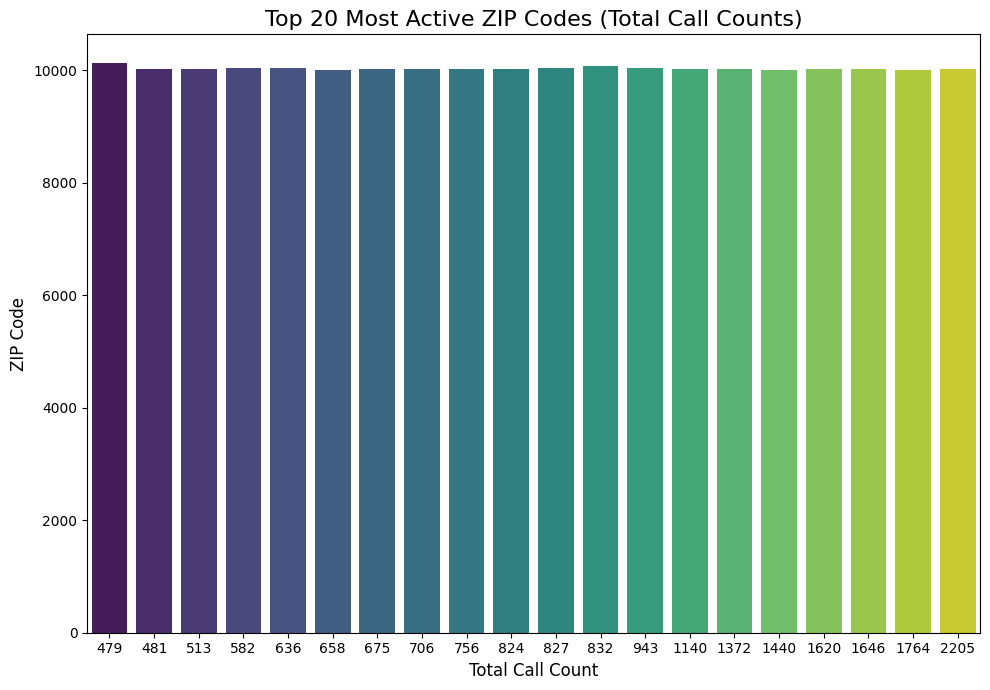

Bar plot for top ZIP Codes generated.

--- Generating Target Area Heatmap (Average Hourly Calls per Top ZIP Code) ---


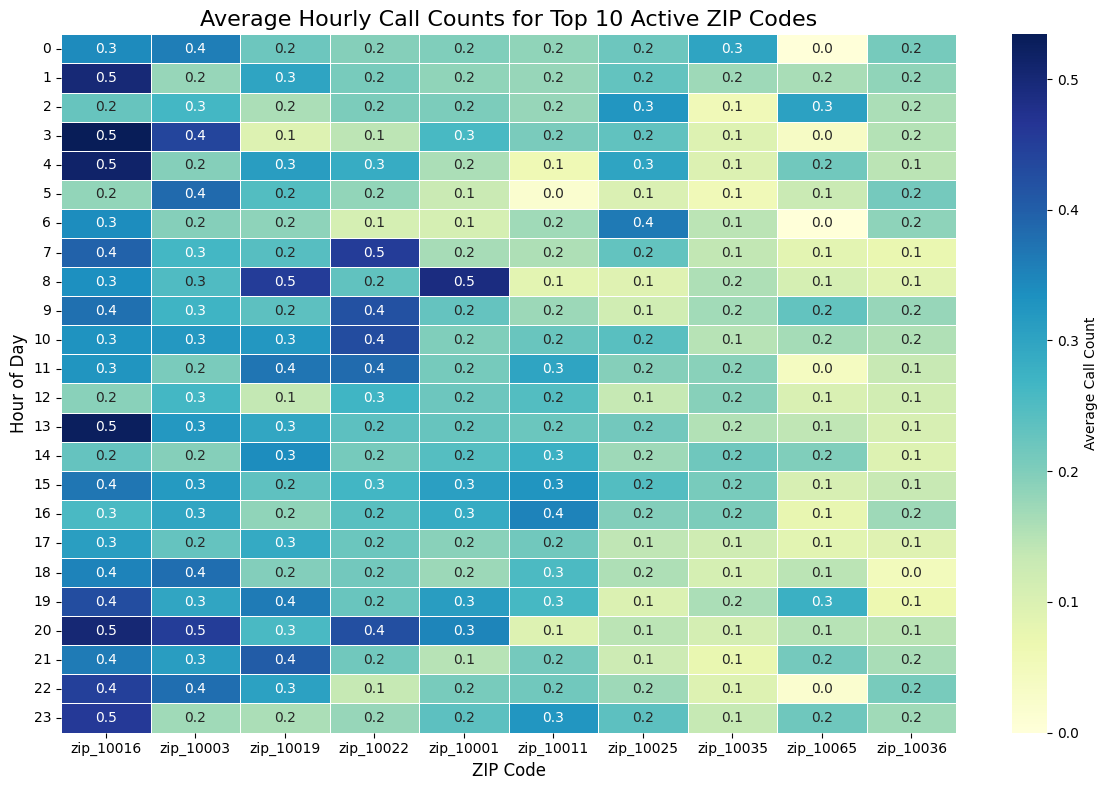

Dataset heatmap for target area generated.


In [ ]:
# File: visualization.py

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

dummy_df = df

# Call the data preparation function to get original_df and processed data shapes
# We don't need X_train, etc., directly here, but need to know the shapes
X_train, y_train, X_val, y_val, X_test, y_test, num_zip_codes, hour_length, original_df_for_plot = prepare_time_series_data(dummy_df)


# Load histories and test results saved from model_training.py
try:
    model_histories = np.load('model_histories.npy', allow_pickle=True).item()
    model_test_results = np.load('model_test_results.npy', allow_pickle=True).item()
except FileNotFoundError:
    print("Error: 'model_histories.npy' or 'model_test_results.npy' not found.")
    print("Please run model_training.py first to generate these files.")
    model_histories = {}
    model_test_results = {}
except Exception as e:
    print(f"An error occurred loading model histories/results: {e}")
    model_histories = {}
    model_test_results = {}


if __name__ == '__main__':
    # --- Figures Demonstrating Experiment Results ---
    print("\n--- Generating Training History Plots (Loss & MAE) ---")

    def plot_history(history, model_name):
        if not history: # Check if dictionary is empty
            print(f"History object for {model_name} is empty or None. Skipping plot.")
            return

        hist_df = pd.DataFrame(history.history)
        epochs = hist_df.index.values + 1

        plt.figure(figsize=(14, 6))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, hist_df['loss'], label='Training Loss')
        if 'val_loss' in hist_df.columns:
            plt.plot(epochs, hist_df['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss Over Epochs', fontsize=14)
        plt.xlabel('Epoch', fontsize=10)
        plt.ylabel('Loss (MSE)', fontsize=10)
        plt.legend(fontsize=9)
        plt.grid(True)

        # Plot MAE
        plt.subplot(1, 2, 2)
        plt.plot(epochs, hist_df['mae'], label='Training MAE')
        if 'val_mae' in hist_df.columns:
            plt.plot(epochs, hist_df['val_mae'], label='Validation MAE')
        plt.title(f'{model_name} MAE Over Epochs', fontsize=14)
        plt.xlabel('Epoch', fontsize=10)
        plt.ylabel('MAE', fontsize=10)
        plt.legend(fontsize=9)
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    # Plot for each model if history is available
    for model_name, history in model_histories.items():
        plot_history(history, model_name)


    # --- Compare Final Test Metrics ---
    print("\n--- Comparing Final Test Set Performance ---")

    if model_test_results:
        model_names = list(model_test_results.keys())
        test_losses = [res[0] for res in model_test_results.values()] # loss is MSE
        test_maes = [res[1] for res in model_test_results.values()]

        x = np.arange(len(model_names))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 6))
        rects1 = ax.bar(x - width/2, test_losses, width, label='Test Loss (MSE)', color='skyblue')
        rects2 = ax.bar(x + width/2, test_maes, width, label='Test MAE', color='lightcoral')

        ax.set_ylabel('Metric Value', fontsize=12)
        ax.set_title('Test Set Performance (Loss & MAE)', fontsize=16)
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45, ha="right", fontsize=10)
        ax.legend(fontsize=10)
        ax.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("No model test results available to compare.")


    # --- Figure Showing Target Area of Dataset (Bar Plot - Kept as a useful overall view) ---
    print("\n--- Generating Target Area Visualization (Bar Plot of Top ZIP Codes) ---")

    if 'ZIP_CODE' in original_df_for_plot.columns:
        df_cleaned = original_df_for_plot.dropna(subset=['ZIP_CODE']).copy()
        df_cleaned['ZIP_CODE'] = df_cleaned['ZIP_CODE'].astype(int)

        zip_code_counts = df_cleaned['ZIP_CODE'].value_counts().reset_index()
        zip_code_counts.columns = ['ZIP_CODE', 'Call_Count']
        zip_code_counts = zip_code_counts.sort_values(by='Call_Count', ascending=False)

        plt.figure(figsize=(10, 7))
        sns.barplot(x='Call_Count', y='ZIP_CODE', data=zip_code_counts.head(20), palette='viridis')
        plt.title('Top 20 Most Active ZIP Codes (Total Call Counts)', fontsize=16)
        plt.xlabel('Total Call Count', fontsize=12)
        plt.ylabel('ZIP Code', fontsize=12)
        plt.tight_layout()
        plt.show()
        print("Bar plot for top ZIP Codes generated.")
    else:
        print("Cannot generate bar plot for 'Target Area': 'ZIP_CODE' column not found in the original DataFrame.")


    # --- NEW: Dataset Heatmap for Target Area of Study (Average Hourly Calls per Top ZIP Code) ---
    print("\n--- Generating Target Area Heatmap (Average Hourly Calls per Top ZIP Code) ---")

    # Re-create pivoted_df if not already available in this scope, or ensure it's passed
    # For visualization.py, it's typically run after data_preparation.py, so we need to
    # re-generate it using the original_df_for_plot.
    if 'INCIDENT_DATETIME' in original_df_for_plot.columns and 'ZIP_CODE' in original_df_for_plot.columns:
        temp_df = original_df_for_plot.copy()
        temp_df['INCIDENT_DATETIME'] = pd.to_datetime(temp_df['INCIDENT_DATETIME'])
        temp_df['hour'] = temp_df['INCIDENT_DATETIME'].dt.hour
        temp_df['date'] = temp_df['INCIDENT_DATETIME'].dt.date

        # Group by 'date', 'hour', and 'ZIP_CODE' to count calls
        calls_per_date_hour_zip = temp_df.groupby(['date', 'hour', 'ZIP_CODE']).size().reset_index(name='call_count')

        # Pivot to get calls per hour per zip
        pivoted_full_data = calls_per_date_hour_zip.pivot_table(
            index=['date', 'hour'],
            columns='ZIP_CODE',
            values='call_count'
        ).fillna(0).reset_index()

        # Rename ZIP_CODE columns for consistency and selection
        old_zip_cols_piv = [col for col in pivoted_full_data.columns if isinstance(col, (int, float)) and col not in ['hour']]
        new_zip_cols_piv = [f'zip_{int(col)}' for col in old_zip_cols_piv]
        rename_dict_piv = dict(zip(old_zip_cols_piv, new_zip_cols_piv))
        pivoted_full_data = pivoted_full_data.rename(columns=rename_dict_piv)

        zip_cols_piv = [col for col in pivoted_full_data.columns if col.startswith('zip_')]

        # Get the top N most active zip codes based on total calls (from the overall original_df)
        top_n_zips = zip_code_counts['ZIP_CODE'].head(10).tolist() # Get top 10 as int
        top_n_zip_cols = [f'zip_{z}' for z in top_n_zips] # Convert to column names

        # Filter pivoted_full_data for only these top N zip codes
        # and include 'hour' for grouping
        heatmap_data = pivoted_full_data[['hour'] + top_n_zip_cols]

        # Calculate the average call count for each hour across the top N zip codes
        average_hourly_calls_per_zip = heatmap_data.groupby('hour')[top_n_zip_cols].mean()

        plt.figure(figsize=(12, 8))
        sns.heatmap(average_hourly_calls_per_zip, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Average Call Count'})
        plt.title('Average Hourly Call Counts for Top 10 Active ZIP Codes', fontsize=16)
        plt.xlabel('ZIP Code', fontsize=12)
        plt.ylabel('Hour of Day', fontsize=12)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        print("Dataset heatmap for target area generated.")
    else:
        print("Cannot generate target area heatmap: Required columns not found or data not suitable.")

In [ ]:
Before hyperparametertuning:
LSTM Test Loss (MSE): 0.3956
LSTM Test MAE: 0.1638
LSTM Test MSE: 0.3956


TCN Test Loss (MSE): 0.3971
TCN Test MAE: 0.1707
TCN Test MSE: 0.3971

Transformer Test Loss (MSE): 0.3986
Transformer Test MAE: 0.1847
Transformer Test MSE: 0.3986

MLP Test Loss (MSE): 0.3950
MLP Test MAE: 0.1604
MLP Test MSE: 0.3950

After Hyperparametertuning:

LSTM:
Best Model Test Loss (MSE): 0.3953
Best Model Test MAE: 0.1708
Best Model Test MSE: 0.3953

Best TCN Model Test Loss (MSE): 0.3970
Best TCN Model Test MAE: 0.1731
Best TCN Model Test MSE: 0.3970

Best Transformer Model Test Loss (MSE): 0.3947
Best Transformer Model Test MAE: 0.1694
Best Transformer Model Test MSE: 0.3947

Best MLP Model Test Loss (MSE): 0.3942
Best MLP Model Test MAE: 0.1689
Best MLP Model Test MSE: 0.3942


In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Simulated ZIP data
zip_data = {
    'ZIP': ['10001', '10003', '10011', '10016', '10019', '10022', '10025', '10035', '10065', '10036'],
    'lat': [40.7506, 40.7312, 40.7421, 40.7465, 40.7651, 40.7580, 40.7968, 40.8022, 40.7661, 40.7590],
    'lon': [-73.9969, -73.9896, -74.0008, -73.9780, -73.9855, -73.9677, -73.9680, -73.9336, -73.9646, -73.9918],
    'call_volume': [0.5, 0.4, 0.3, 0.5, 0.3, 0.2, 0.4, 0.2, 0.1, 0.2]
}

df_zip = pd.DataFrame(zip_data)
df_zip['text'] = 'ZIP ' + df_zip['ZIP'] + '<br>Avg Call Volume: ' + df_zip['call_volume'].astype(str)
scale = 50

# Plotly Map
fig = go.Figure()

fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    lon=df_zip['lon'],
    lat=df_zip['lat'],
    text=df_zip['text'],
    marker=dict(
        size=df_zip['call_volume'] * scale,
        color='crimson',
        line_color='rgb(40,40,40)',
        line_width=0.5,
        sizemode='area',
        opacity=0.8
    ),
    name='NYC ZIP Call Volume'
))

fig.update_layout(
    title_text='NYC ZIP Code EMS Call Volume (Approximate Locations)',
    showlegend=False,
    geo=dict(
        scope='usa',
        landcolor='rgb(217, 217, 217)',
        center=dict(lat=40.75, lon=-73.97),
        projection_scale=20,
        resolution=50,
    )
)

fig.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Upload your file in Colab or mount Google Drive
# For example:
# from google.colab import files
# uploaded = files.upload()

# Load your EMS CSV file
df = pd.read_csv("/content/000.part.csv")  # Change path if needed

# Aggregate EMS call counts by ZIP
df = df[df['ZIP_CODE'].notna()]
df['ZIP'] = df['ZIP_CODE'].astype(int).astype(str)
zip_call_counts = df.groupby('ZIP').size().reset_index(name='call_count')

# NYC ZIP centroids (approximate)
zip_coords = {
    '10001': (40.7506, -73.9969), '10002': (40.7170, -73.9870), '10003': (40.7312, -73.9896),
    '10004': (40.7021, -74.0122), '10005': (40.7060, -74.0088), '10006': (40.7085, -74.0134),
    '10007': (40.7130, -74.0072), '10009': (40.7270, -73.9785), '10010': (40.7380, -73.9826),
    '10011': (40.7421, -74.0008), '10012': (40.7252, -73.9986), '10013': (40.7208, -74.0059),
    '10014': (40.7350, -74.0053), '10016': (40.7465, -73.9780), '10017': (40.7520, -73.9725),
    '10018': (40.7551, -73.9935), '10019': (40.7651, -73.9855), '10020': (40.7590, -73.9792),
    '10021': (40.7684, -73.9607), '10022': (40.7580, -73.9677), '10023': (40.7756, -73.9822),
    '10024': (40.7864, -73.9776), '10025': (40.7968, -73.9680), '10026': (40.8020, -73.9552),
    '10027': (40.8100, -73.9530), '10028': (40.7762, -73.9546), '10029': (40.7916, -73.9448),
    '10030': (40.8183, -73.9421), '10031': (40.8230, -73.9500), '10032': (40.8400, -73.9419),
    '10033': (40.8500, -73.9360), '10034': (40.8677, -73.9223), '10035': (40.8022, -73.9336),
    '10036': (40.7590, -73.9918), '10037': (40.8130, -73.9400), '10038': (40.7095, -74.0037),
    '10039': (40.8300, -73.9371), '10040': (40.8584, -73.9291)
}

# Add lat/lon
zip_call_counts['lat'] = zip_call_counts['ZIP'].map(lambda z: zip_coords.get(z, (None, None))[0])
zip_call_counts['lon'] = zip_call_counts['ZIP'].map(lambda z: zip_coords.get(z, (None, None))[1])
zip_call_counts = zip_call_counts.dropna()

# Call count buckets and colors
limits = [(0, 100), (100, 300), (300, 700), (700, 1500), (1500, 3000)]
colors = ["royalblue", "crimson", "lightseagreen", "orange", "lightgrey"]

# Plot
fig = go.Figure()

for i, lim in enumerate(limits):
    df_sub = zip_call_counts[(zip_call_counts['call_count'] > lim[0]) & (zip_call_counts['call_count'] <= lim[1])]
    fig.add_trace(go.Scattergeo(
        locationmode='USA-states',
        lon=df_sub['lon'],
        lat=df_sub['lat'],
        text="ZIP " + df_sub['ZIP'] + "<br>Calls: " + df_sub['call_count'].astype(str),
        marker=dict(
            size=df_sub['call_count'] / 5,
            color=colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode='area'
        ),
        name='{0}–{1} Calls'.format(lim[0], lim[1])
    ))

fig.update_layout(
    title_text='NYC EMS Call Volume by ZIP Code',
    showlegend=True,
    geo=dict(
        scope='usa',
        landcolor='rgb(217, 217, 217)',
        center=dict(lat=40.75, lon=-73.97),
        projection_scale=20
    )
)

fig.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load EMS CSV file
df = pd.read_csv("/content/000.part.csv")

# Aggregate call counts by ZIP
df = df[df['ZIP_CODE'].notna()]
df['ZIP'] = df['ZIP_CODE'].astype(int).astype(str)
zip_call_counts = df.groupby('ZIP').size().reset_index(name='call_count')

# Approximate NYC ZIP centroids
zip_coords = {
    '10001': (40.7506, -73.9969), '10002': (40.7170, -73.9870), '10003': (40.7312, -73.9896),
    '10004': (40.7021, -74.0122), '10005': (40.7060, -74.0088), '10006': (40.7085, -74.0134),
    '10007': (40.7130, -74.0072), '10009': (40.7270, -73.9785), '10010': (40.7380, -73.9826),
    '10011': (40.7421, -74.0008), '10012': (40.7252, -73.9986), '10013': (40.7208, -74.0059),
    '10014': (40.7350, -74.0053), '10016': (40.7465, -73.9780), '10017': (40.7520, -73.9725),
    '10018': (40.7551, -73.9935), '10019': (40.7651, -73.9855), '10020': (40.7590, -73.9792),
    '10021': (40.7684, -73.9607), '10022': (40.7580, -73.9677), '10023': (40.7756, -73.9822),
    '10024': (40.7864, -73.9776), '10025': (40.7968, -73.9680), '10026': (40.8020, -73.9552),
    '10027': (40.8100, -73.9530), '10028': (40.7762, -73.9546), '10029': (40.7916, -73.9448),
    '10030': (40.8183, -73.9421), '10031': (40.8230, -73.9500), '10032': (40.8400, -73.9419),
    '10033': (40.8500, -73.9360), '10034': (40.8677, -73.9223), '10035': (40.8022, -73.9336),
    '10036': (40.7590, -73.9918), '10037': (40.8130, -73.9400), '10038': (40.7095, -74.0037),
    '10039': (40.8300, -73.9371), '10040': (40.8584, -73.9291)
}

# Add lat/lon
zip_call_counts['lat'] = zip_call_counts['ZIP'].map(lambda z: zip_coords.get(z, (None, None))[0])
zip_call_counts['lon'] = zip_call_counts['ZIP'].map(lambda z: zip_coords.get(z, (None, None))[1])
zip_call_counts = zip_call_counts.dropna()

# Call count buckets and colors
limits = [(0, 100), (100, 300), (300, 700), (700, 1500), (1500, 3000)]
colors = ["royalblue", "crimson", "lightseagreen", "orange", "lightgrey"]

# Plot
fig = go.Figure()

for i, lim in enumerate(limits):
    df_sub = zip_call_counts[(zip_call_counts['call_count'] > lim[0]) & (zip_call_counts['call_count'] <= lim[1])]
    fig.add_trace(go.Scattergeo(
        locationmode='USA-states',
        lon=df_sub['lon'],
        lat=df_sub['lat'],
        text="ZIP " + df_sub['ZIP'] + "<br>Calls: " + df_sub['call_count'].astype(str),
        marker=dict(
            size=df_sub['call_count'] / 2,  # ⬅️ increase bubble size
            color=colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode='area'
        ),
        name='{0}–{1} Calls'.format(lim[0], lim[1])
    ))

fig.update_layout(
    title_text='NYC EMS Call Volume by ZIP Code',
    showlegend=True,
    geo=dict(
        scope='usa',
        landcolor='rgb(217, 217, 217)',
        center=dict(lat=40.76, lon=-73.97),  # ⬅️ better NYC center
        projection_scale=100,  # ⬅️ tighter zoom on city
        resolution=50,
        showland=True,
        showcountries=False,
        showlakes=False,
        showocean=False
    )
)

fig.show()
